In [1]:
%load_ext autoreload

In [2]:
%autoreload
import sys
sys.path.insert(0, '../')

In [3]:
from src.utilities.mluar_utils import *

/mnt/swordfish-pool2/milad/conda-envs/huggingface-tlr/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset, Dataset
import numpy as np
from einops import rearrange, reduce, repeat
import torch
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import math

In [5]:
MULTI_LUAR_PATH =  "/mnt/swordfish-pool2/milad/Multi-LUAR/src/reddit_model/"
LUAR_PATH =  "/mnt/swordfish-pool2/nikhil/LUAR/pretrained_weights/LUAR-MUD/"

In [6]:
analyzed_labels = [
    'Formal / Informal',
    'Active / Passive',
    'With frequent punctuation / Less Frequent punctuation',
    'Offensive / Non-Offensive',
    'Positive / Negative',
]

In [7]:
# Load models
multiluar_model = AutoModel.from_pretrained(MULTI_LUAR_PATH, trust_remote_code=True)
luar_model = AutoModel.from_pretrained(LUAR_PATH, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("rrivera1849/LUAR-MUD")

In [8]:
# Load data
style_distance_dataset = load_dataset('StyleDistance/synthstel')
# Create author for each style feature
author_lvl_style_dataset= merge_texts_to_authors_per_label(style_distance_dataset['train'].filter(lambda row: row['feature'] in analyzed_labels), 5)

In [9]:
author_lvl_style_dataset

Dataset({
    features: ['positive', 'negative', 'feature'],
    num_rows: 25
})

In [10]:
max_seq_length = 320 # longest sequence is 320
# Get embeddings from multi-luar
positives_embeddings = get_luar_embeddings(author_lvl_style_dataset['positive'], multiluar_model, tokenizer, max_length=max_seq_length, batch_size=5, is_multi_luar=True)
negatives_embeddings = get_luar_embeddings(author_lvl_style_dataset['negative'], multiluar_model, tokenizer, max_length=max_seq_length, batch_size=5, is_multi_luar=True)
labels = author_lvl_style_dataset['feature']

# Get embeddings from Luar
positives_luar_embeddings = get_luar_embeddings(author_lvl_style_dataset['positive'], luar_model, tokenizer, max_length=max_seq_length, batch_size=5)
negatives_luar_embeddings = get_luar_embeddings(author_lvl_style_dataset['negative'], luar_model, tokenizer, max_length=max_seq_length, batch_size=5)
positives_luar_embeddings = [e.unsqueeze(0) for e in positives_luar_embeddings]
negatives_luar_embeddings = [e.unsqueeze(0) for e in negatives_luar_embeddings]

In [11]:
# Compute Multi-luar similarity matrices at every layer and average of the layers
muti_luar_layers_sims = [compute_similarities(positives_embeddings, negatives_embeddings, layer=i) for i in range(7)]
muti_luar_layers_sims.append(compute_similarities(positives_embeddings, negatives_embeddings, layer=None))

In [12]:
# Compute Luar similarity matrices (only final layer)
luar_sim_matrix = compute_similarities(positives_luar_embeddings, negatives_luar_embeddings, layer=None)

In [13]:
compute_mrr(luar_sim_matrix, labels)

np.float64(0.331)

In [14]:
[compute_mrr(s, labels) for s in muti_luar_layers_sims]

[np.float64(0.331),
 np.float64(0.201),
 np.float64(0.254),
 np.float64(0.251),
 np.float64(0.273),
 np.float64(0.296),
 np.float64(0.278),
 np.float64(0.274)]

In [17]:
def compute_layer_to_features_significance(muti_luar_layers_sims, labels):
    layer_to_feat_score = []
    unique_labels = set(labels)
    for label in unique_labels:
        label_indices = np.where(np.array(labels) == label)[0]
        other_labels_indices = np.where(np.array(labels) != label)[0]
        #print(label_indices)
        label_sims = []
        for layer in range(7):
            muti_luar_layer_sim = muti_luar_layers_sims[layer]
            label_matrix = np.take(muti_luar_layer_sim, label_indices, axis=0)
            label_matrix = np.take(label_matrix, label_indices, axis=1)

            other_labels_matrix = np.take(muti_luar_layer_sim, other_labels_indices, axis=0)
            other_labels_matrix = np.take(other_labels_matrix, other_labels_indices, axis=1)
            
            #print(label_matrix)
            label_sims.append(round(float(np.mean(label_matrix)/np.mean(other_labels_matrix)), 2))
        layer_to_feat_score.append(label_sims)
    return layer_to_feat_score

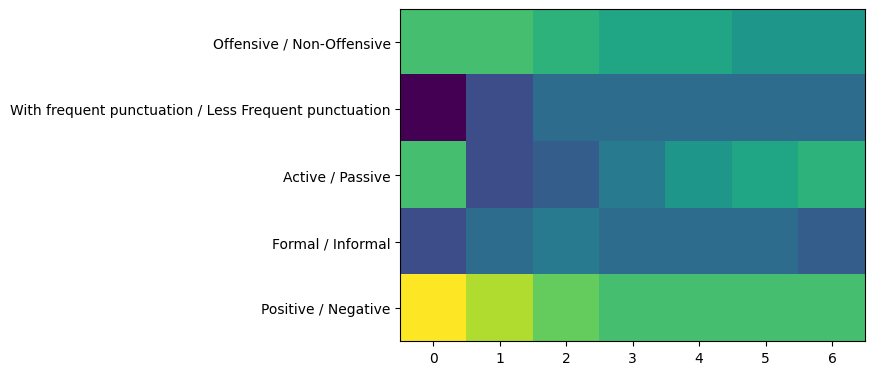

In [18]:
layer_to_feat_score = compute_layer_to_features_significance(muti_luar_layers_sims, labels)
fig, ax = plt.subplots(figsize=(6,12))
ax.imshow(layer_to_feat_score)
ax.set(yticks = range(len(set(labels))), yticklabels=set(labels))
plt.show()

In [20]:
layer_to_feat_score[2]

[1.04, 0.96, 0.97, 0.99, 1.01, 1.02, 1.03]

### Clustering

In [21]:
from sklearn.manifold import TSNE

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plot_tsne(embeddings, labels, layer):
    fig, ax = plt.subplots(figsize=(6,3))
    X =  np.array([elem.numpy() for elem in embeddings])
    X = X[:, layer, :]
    
    X_embedded = TSNE(n_components=2, learning_rate='auto',
                      init='pca', random_state=123, metric='cosine').fit_transform(X)
    x = X_embedded[:,0]
    y = X_embedded[:,1]
    
    
    label_set = list(set(labels))
    color_map = get_cmap(len(label_set))
    label_set_colors = {x: color_map(i) for i, x in enumerate(label_set)}
    label_colors = [label_set_colors[label] for label in labels]

    for i, label in enumerate(label_set):
        label_indices = np.where(np.array(labels) == label)[0]
        sc = plt.scatter(x[label_indices], y[label_indices], color=label_set_colors[label], label=label)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

/tmp/ipykernel_2904956/2904967363.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return plt.cm.get_cmap(name, n)


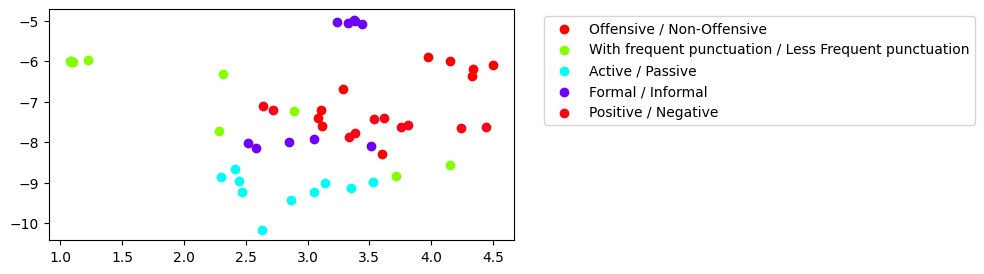

In [22]:
plot_tsne(positives_embeddings + negatives_embeddings, labels+labels, layer=0)

/tmp/ipykernel_2904956/2904967363.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return plt.cm.get_cmap(name, n)


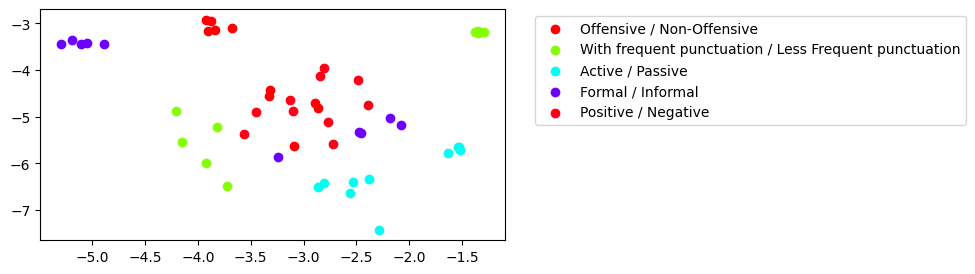

In [23]:
plot_tsne(positives_embeddings + negatives_embeddings, labels+labels, layer=3)

/tmp/ipykernel_2904956/2904967363.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return plt.cm.get_cmap(name, n)


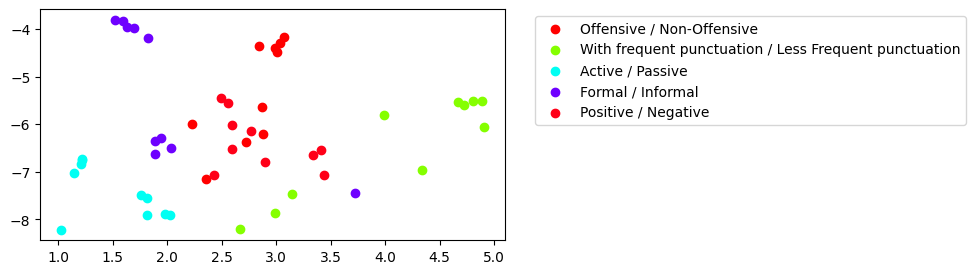

In [27]:
plot_tsne(positives_embeddings + negatives_embeddings, labels+labels, layer=6)